In [3]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import SDWriter
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import rdmolops
from rdkit.Chem import rdchem

from molvs import Standardizer

#insert path to python scripts
sys.path.insert(1, os.environ['BASE'] + "/modules")

from draw_2d import *
from draw_3d import drawit

In [4]:
ifilename = os.environ['BASE'] + "/molekula.txt"
plumed = "/opt/podman-run.py --root=/scratch.ssd/xvisnov1/tmp run -v work:/tmp ljocha/plumed plumed"
gromacs_s = "cd /opt; ./gmx" #gmx_mpi
gromacs_d = "cd /opt; ./gmx -d" #double precision gromacs

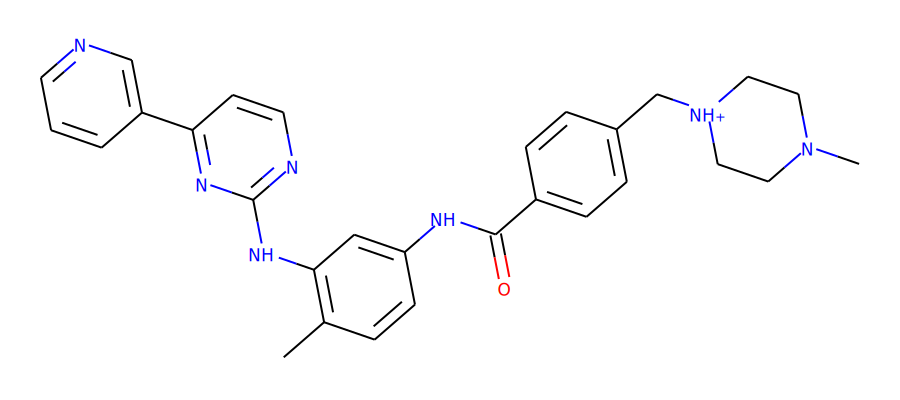

In [5]:
ifile = open(ifilename, "r").readlines()
smiles_molecule = str.split(ifile[0])[0]

molecule = Chem.MolFromSmiles(smiles_molecule)

render_svg(moltosvg(molecule))

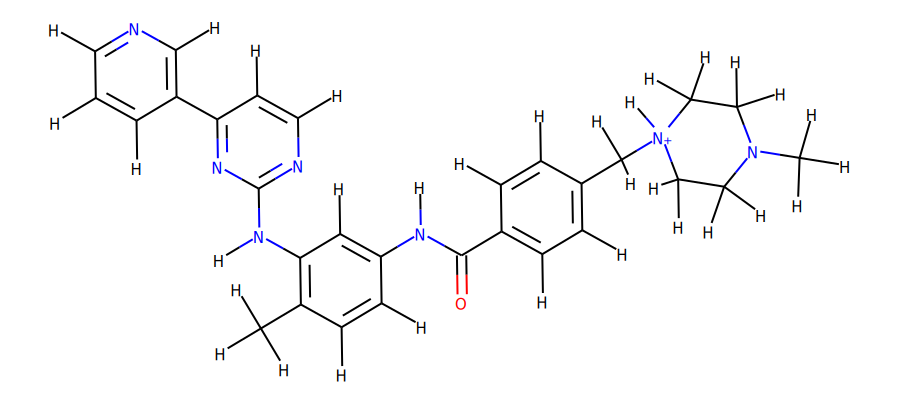

In [6]:
smifile = open("molekula.smi", "w")
smifile.write(smiles_molecule)
smifile.close()

molecule = Chem.MolFromSmiles(smiles_molecule)
s = Standardizer()
molecule = s.standardize(molecule)
molecule = Chem.AddHs(molecule)
natoms = molecule.GetNumAtoms()

render_svg(moltosvg(molecule))

In [7]:
#set parameters
numc = 50 #00
minid = 0
minene = 100000000000.0

In [8]:
#find most stable configuration
molecules = AllChem.EmbedMultipleConfs(molecule, clearConfs=True, numConfs=numc)
done = AllChem.MMFFOptimizeMoleculeConfs(molecule)

for i in range(len(done)):
  if done[i][1]<minene:
    minene = done[i][1]
    minid = i
print(f'minid: {minid}')
print(f'minene: {minene}')

writer = SDWriter("molekula.mol")
writer.write(molecule, confId=minid)

drawit(molecule)

minid: 19
minene: 78.80308914244146


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
RotatableBond = Chem.MolFromSmarts('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]')
rotatables = molecule.GetSubstructMatches(RotatableBond)
print(rotatables)

((2, 24), (8, 10), (13, 16), (16, 17), (24, 25), (29, 31))


In [10]:
torsions = []
for rotatable in rotatables:
  pairs1 = []
  pairs2 = []
  for bond in molecule.GetBonds():
    if rotatable[0]==bond.GetBeginAtomIdx() and rotatable[1]!=bond.GetEndAtomIdx():
      pairs1.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
    if rotatable[1]==bond.GetBeginAtomIdx() and rotatable[0]!=bond.GetEndAtomIdx():
      pairs2.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
  torsions.append([pairs1[0][1],pairs1[0][0],pairs2[0][0],pairs2[0][1]])
print(torsions)

[[3, 2, 24, 25], [9, 8, 10, 11], [14, 13, 16, 17], [48, 16, 17, 18], [62, 24, 25, 26], [30, 29, 31, 32]]


In [11]:
netcharge = rdmolops.GetFormalCharge(molecule)
command = "antechamber -i molekula.mol -fi mdl -o molekula.prepi \
           -fo prepi -c bcc -nc "+str(netcharge)
os.system(command)

command = "parmchk2 -i molekula.prepi -f prepi -o molekula.frcmod"
os.system(command)

command = "tleap -f tleapin.txt"
os.system(command)

command = "acpype -p molekula.prmtop -x molekula.inpcrd"
os.system(command)

os.system("mkdir em")
emfile = open("em/em.mdp", "w")
emfile.write("integrator          =  steep\n")
emfile.write("nsteps              =  100000\n")
emfile.write("emtol               =  0\n")
emfile.write("emstep              =  0.1\n")
emfile.write("nstcomm             =  1\n")
emfile.write("nstxout             =  100\n")
emfile.write("nstvout             =  100\n")
emfile.write("nstfout             =  0\n")
emfile.write("nstlog              =  100\n")
emfile.write("nstenergy           =  100\n")
emfile.write("nstlist             =  1\n")
emfile.write("ns_type             =  grid\n")
emfile.write("coulombtype         =  cut-off\n")
emfile.write("rlist               =  1.4\n")
emfile.write("rcoulomb            =  1.4\n")
emfile.write("rvdw                =  1.4\n")
emfile.write("energygrps          =  System\n")
emfile.write("epsilon-r           =  80\n")
emfile.write("\n")
emfile.close()
os.system("cp MOL_GMX.gro em/")
os.system("cp MOL_GMX.top em/")
command = gromacs_s + " -w /em editconf -f MOL_GMX -o box -c -box 3 3 3"
os.system(command)
command = gromacs_s + " -w /em grompp -f em.mdp -c box -p MOL_GMX -o em1"
os.system(command)
command = gromacs_d + " -w /em mdrun -deffnm em1"
os.system(command)

0

In [34]:
command = "/opt/podman-run.py --root=/scratch.ssd/xvisnov1/tmp run -v work/em:/tmp ljocha/gromacs_avx2_d:2020.01.14-1 gmx editconf -f MOL_GMX -o box -c -box 3 3 3"
os.system(command)

0

In [ ]:
os.system("mkdir md")
mdfile = open("md/md.mdp", "w")
mdfile.write("integrator          = sd\n")
mdfile.write("nsteps              = 100000\n")
mdfile.write("dt                  = 0.001\n")
mdfile.write("nstxout             = 1000\n")
mdfile.write("nstvout             = 1000\n")
mdfile.write("nstenergy           = 1000\n")
mdfile.write("nstlog              = 1000\n")
mdfile.write("continuation        = no\n")
mdfile.write("constraints         = none\n")
mdfile.write("cutoff-scheme       = Verlet\n")
mdfile.write("ns_type             = grid\n")
mdfile.write("nstlist             = 1\n")
mdfile.write("rlist               = 1.4\n")
mdfile.write("rcoulomb            = 1.4\n")
mdfile.write("rvdw                = 1.4\n")
mdfile.write("coulombtype         = cut-off\n")
mdfile.write("tcoupl              = V-rescale\n")
mdfile.write("tc-grps             = system\n")
mdfile.write("tau_t               = 0.1\n")
mdfile.write("ref_t               = 300\n")
mdfile.write("pcoupl              = no\n")
mdfile.write("pbc                 = xyz\n")
mdfile.write("gen_vel             = yes\n")
mdfile.write("epsilon-r           = 80\n")
mdfile.write("\n")
mdfile.close()
os.system("cp em/em1.gro md/")
os.system("cp MOL_GMX.top md/")
command = gromacs_s + " -w /md grompp -f md.mdp -c em1 -p MOL_GMX -o md1"
os.system(command)
command = gromacs_d + " -w /md mdrun -deffnm md1"
os.system(command)

In [ ]:
command = "echo 0 | " + gromacs_s + " trjconv -s md/md1.tpr -f md/md1.trr -o outTraj.pdb"
os.system(command)

import nglview as nv
import pytraj as pt

traj = pt.load('outTraj.pdb')
view = nv.show_pytraj(traj)
view

In [ ]:
for i in range(len(torsions)):
  fr = str(float(100-len(torsions)+i)-0.01)
  to = str(float(100-len(torsions)+i)+0.01)
  command = gromacs_s + " -w /md trjconv -pbc nojump \
                                      -s md1 -f md1 -o frame"+str(i)+".gro \
                                      -b "+fr+" -e "+to+"<<EOF\n0\nEOF"
  os.system(command)

In [ ]:
os.system("mkdir mtd")
mtdfile = open("mtd/mtd.mdp", "w")
mtdfile.write("integrator          = sd\n")
mtdfile.write("nsteps              = 1000000\n")
mtdfile.write("dt                  = 0.001\n")
mtdfile.write("nstxout             = 1000\n")
mtdfile.write("nstvout             = 1000\n")
mtdfile.write("nstenergy           = 1000\n")
mtdfile.write("nstlog              = 1000\n")
mtdfile.write("continuation        = no\n")
mtdfile.write("constraints         = none\n")
mtdfile.write("cutoff-scheme       = Verlet\n")
mtdfile.write("ns_type             = grid\n")
mtdfile.write("nstlist             = 1\n")
mtdfile.write("rlist               = 1.4\n")
mtdfile.write("rcoulomb            = 1.4\n")
mtdfile.write("rvdw                = 1.4\n")
mtdfile.write("coulombtype         = cut-off\n")
mtdfile.write("tcoupl              = V-rescale\n")
mtdfile.write("tc-grps             = system\n")
mtdfile.write("tau_t               = 0.1\n")
mtdfile.write("ref_t               = 300\n")
mtdfile.write("pcoupl              = no\n")
mtdfile.write("pbc                 = xyz\n")
mtdfile.write("gen_vel             = yes\n")
mtdfile.write("epsilon-r           = 80\n")
mtdfile.write("\n")
mtdfile.close()

In [ ]:
for i in range(len(torsions)):
  os.system("mkdir mtd/w"+str(i))
  plumeddat = open("mtd/w"+str(i)+"/plumed.dat", "w")
  plumeddat.write("RANDOM_EXCHANGES\n")
  plumeddat.write("WHOLEMOLECULES ENTITY0=1-%i\n" % natoms)
  for j in range(len(torsions)):
    plumeddat.write("TORSION ATOMS=%i,%i,%i,%i LABEL=cv%i\n" % (torsions[j][0],torsions[j][1],torsions[j][2],torsions[j][3],j+1))
  plumeddat.write("METAD ARG=cv%i HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi GRID_MAX=pi BIASFACTOR=15 LABEL=be\n" % (i+1))
  cvs = ""
  for j in range(len(torsions)):
    cvs=cvs+"cv"+str(j+1)+","
  cvs = cvs[:-1]
  plumeddat.write("PRINT ARG=%s STRIDE=1000 FILE=COLVAR\n" % cvs)
  plumeddat.write("PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n")
  plumeddat.close()

os.system("cp MOL_GMX.top mtd/")

In [ ]:
for i in range(len(torsions)):
  os.system("cp md/frame"+str(i)+".* mtd/w"+str(i)+"/")
  command = gromacs_s + " -w /mtd grompp -f mtd.mdp -c w" +str(i)+"/frame"+str(i)+" -p MOL_GMX -o w" +str(i)+"/mtd1"
  os.system(command)

In [ ]:
command = gromacs_d + " -d -n "+ str(len(torsions)) +" -w /mtd mdrun -deffnm mtd1 -replex 500 -plumed plumed.dat -multidir "
for i in range(len(torsions)):
  command = command + "w"+str(i)+" "
os.system(command)

In [ ]:
#cluster structures
command = "(echo 0; sleep 1; echo 0) | " + gromacs_s + " cluster -method gromos -cl clustering/outCluster.pdb -s md/md1.tpr -f md/md1.trr"
os.system(command)

In [ ]:
#divide all clusters from gmx cluster to single clusters
with open("clustering/outCluster.pdb") as input_cluster:
    i = 0
    outFile = open("clustering/outClustersPDB/outCluster" + str(i) + ".pdb", "w")
    for line in input_cluster:
        if line != "ENDMDL\n":
            outFile.write(line)
            continue
        outFile.write("ENDMDL\n")
        i += 1
        outFile = open("clustering/outClustersPDB/outCluster" + str(i) + ".pdb", "w")
os.system("rm clustering/outClustersPDB/outCluster" + str(i) + ".pdb")
clusters_count = i

In [ ]:
from convert import *
from execute_orca import *

#convert .pdb clusters to .xyz
for pdb_cluster in os.listdir("clustering/outClustersPDB/"):
    command = "babel -ipdb clustering/outClustersPDB/" + pdb_cluster + " -oxyz clustering/outClustersXYZ/" + pdb_cluster.replace("pdb", "xyz")
    os.system(command)

In [ ]:
#convert to !Am1 Opt methods
convert_to_orca_methods("clustering/outClustersXYZ/", "/work/am1/input/", torsions, "!AM1 Opt")

In [ ]:
#execute !Am1 Opt orca methods
execute_orca("/work/am1/input/", "/work/am1/output/")

In [ ]:
#convert to !BP86 def2-TZVP TightSCF Opt methods
numOfDirectories = sum(os.path.isdir(os.path.join("/work/am1/output/", i)) for i in os.listdir("/work/am1/output/"))
for i in range(0, numOfDirectories):
    convert_to_orca_methods("/work/am1/output/outCluster" + str(i) + "/", "/work/bp86/input/", torsions, "!BP86 def2-TZVP TightSCF Opt")

In [ ]:
#execute !BP86 def2-TZVP TightSCF Opt orca methods
execute_orca("/work/bp86/input/", "/work/bp86/output/")

In [ ]:
import re

orca_output_file = "orca_output.txt"
orca_energies_file = "orca_energies.txt"
energies_touples = []

with open(orca_output_file) as orca_output:
    orca_output_string = orca_output.read()
    energies_touples = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', orca_output_string)

orca_energies = open(orca_energies_file, "w")
for energy_touple in energies_touples:
    orca_energies.write(energy_touple[2])
    orca_energies.write('\n')
orca_energies.close()

In [ ]:
ifile = open("orca_energies.txt", "r")

energies_in_hartree = []

for line in ifile.readlines():
    energies_in_hartree.append(float(line))

ifile.close()

minimum = min(energies_in_hartree)

energies_in_kJ = []
CONVERSION_CONST = 2625.499638

for H in energies_in_hartree:
    energies_in_kJ.append((H-minimum)*CONVERSION_CONST)

ofile = open("orca_energies.txt", "w")

for energy in energies_in_kJ:
    ofile.write(str(energy) + "\n")

ofile.close()

In [5]:
import os

output_dir = "/work/pdb_opt/"
#input_dir = "/work/bp86/output/"
input_dir = "output/"

os.system("mkdir " + output_dir)

#ifile = open("/work/clustering/outClustersPDB/outCluster0.pdb", "r")
ifile = open("cluster_1.pdb", "r")
atoms = []
for line in ifile.readlines():
    if "ATOM" in line:
        atoms.append(line[:26])
ifile.close()
        
#clusters_count
for i in range(0, 11):
    hetatms = []
    os.system("babel -ixyz {}outCluster{}.xyz -opdb {}temp_cluster_{}.pdb".format(input_dir, str(i), output_dir, str(i)))
    ifile = open("{}temp_cluster_{}.pdb".format(output_dir, str(i)), "r")
    for line in ifile.readlines():
        if "HETATM" in line:
            hetatms.append(line[27:66])
    ifile.close()
    output_cluster = open("pdb_opt/cluster{}.pdb".format(str(i)), "w")
    for i in range(len(atoms)):
        output_cluster.write(atoms[i])
        output_cluster.write(hetatms[i] + "\n")
    output_cluster.close()

os.system("rm {}temp_*".format(output_dir))

0

In [11]:
input_dir = "/work/pdb_opt/"
output_file = "clusters.pdb"
ofile = open(output_file, "w")

#clusters_count
for i in range(0, 11):
    ofile.write("MODEL {}\n".format(str(i)))
    ifile = open("{}cluster{}.pdb".format(input_dir, str(i)), "r")
    ofile.write(ifile.read())
    ofile.write("ENDMDL\n")
    ifile.close()
ifile.close()

os.system("{} driver --plumed plumed.dat --mf_pdb {}".format(plumed, output_file))

ifile = open("DIHEDRALS", "r")
lines = []
for line in ifile.readlines():
    if "#" not in line:
        lines.append(line)
ifile.close()
ofile = open("DIHEDRALS", "w")
for line in lines:
    ofileo.write(line)
ofile.close()

In [ ]:
import math

cv1=[]
cv2=[]
cv3=[]
cv4=[]
cv5=[]
cv6=[]
cvs = open("DIHEDRALS","r").readlines()
for i in range(len(cvs)):
  l = cvs[i].split()
  cv1.append(float(l[1])*(180/math.pi))
  cv2.append(float(l[2])*(180/math.pi))
  cv3.append(float(l[3])*(180/math.pi))
  cv4.append(float(l[4])*(180/math.pi)) 
  cv5.append(float(l[5])*(180/math.pi))
  cv6.append(float(l[6])*(180/math.pi))

def generaterestraint(cv1, cv2, cv3, cv4, cv5, cv6):
  ifile = open("MOL_GMX.top", "r").readlines()
  ofilename = "restrained.top"
  ofile = open(ofilename, "w")
  for line in ifile:
    if line == "; Ligand position restraints\n":
      ofile.write("\n")
      ofile.write("[ dihedral_restraints ]\n")
      ofile.write(" 19 20 23 24 2 %3.1f 0 500\n" %cv1 )
      ofile.write(" 25 32 33 35 2 %3.1f 0 500\n" %cv2 )
      ofile.write(" 33 35 37 47 2 %3.1f 0 500\n" %cv3 )
      ofile.write(" 47 49 50 52 2 %3.1f 0 500\n" %cv4 )
      ofile.write(" 49 50 52 53 2 %3.1f 0 500\n" %cv5 )
      ofile.write(" 53 59 60 61 2 %3.1f 0 500\n" %cv6 )
      ofile.write("\n")
    ofile.write(line)
  ofile.close()

os.system("mkdir gaff")

#clusters_count
for i in range(0, 11): 
    os.system("mkdir gaff/cluster_"+str(i))
    command = "cp cluster_" + str(i) + ".pdb MOL_GMX.top em.mdp md.mdp gaff/cluster_" + str(i)
    os.system(command)
    os.chdir("gaff/cluster_" + str(i))
    generaterestraint(cv1[i-1], cv2[i-1], cv3[i-1], cv4[i-1], cv5[i-1], cv6[i-1])
    os.system("gmx_mpi editconf -f cluster_" + str(i) + ".pdb -box 3 3 3 -bt cubic -c -o box.gro")
    command =  "gmx_mpi grompp -f em -c box.gro -p restrained.top -o em1"
    os.system(command)
    command = "gmx_mpi mdrun -s em1 -c after_em1 -g em1 -e em1 -o em1"
    os.system(command)
    command = "gmx_mpi grompp -f md -c box.gro -p MOL_GMX.top -o rerun"
    os.system(command)
    command = "gmx_mpi mdrun -s rerun -rerun em1 -c after_rerun -g rerun -e rerun -o rerun"
    os.system(command)
    command = "gmx_mpi energy -f rerun.edr -o rerun.xvg <<EOF\n10\nEOF\n"
    os.system(command)
    os.chdir("../..")

In [ ]:
energies_lst = []
#clusters_count
for i in range(0, 11):
    with open("gaff/cluster_{}/rerun.xvg", "r") as ifile:
        last_line = ifile.readlines()[-1]
        energies = last_line.split(" ")
        energies_lst.append(energies[1])

min_energy = min(energies_lst)
for i in range(0, 11):
    with open("gaff_energies.txt", "w") as ofile:
        for energy in energies_lst:
            ofile.write((energy - min_energy))

In [ ]:
ofile = open("reference", "w")

with open("orca_energies.txt", "r") as orca_energies, open("gaff_energies.txt", "r") as gaff_energies:
    for orca_energy in orca_energies.readlines():
        for gaff_energy in gaff_energies.readlines():
            ofile.write((orca_energy - gaff_energy))
        
ofile.close()